# 4.2 Loading a pre-trained model

In [88]:
import torch
import time
import json
import re
from pathlib import Path
from qwen3 import Qwen3Model, KVCache
from utils import render_prompt, generate_text_basic_stream_cache, Qwen3Tokenizer, load_model_and_tokenizer
from IPython.display import Latex, display
from typing import List, Callable, Optional, Tuple, TypedDict, Literal, Generator
from sympy import Expr, simplify
from sympy.parsing import sympy_parser as spp
from sympy.core.sympify import SympifyError
from tokenize import TokenError
from urllib.request import urlopen
import matplotlib.pyplot as plt

In [ ]:
def set_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device(device="cuda")
    elif torch.backends.mps.is_available():
        return torch.device(device="mps")
    else:
        return torch.device(device="cpu")


device = set_device()
print(f"Using device: {device}")

In [46]:
WHICH_MODEL = "base"

In [47]:
raw_prompt = (
    "Half the value of $3x-9$ is $x+37$. "
    "What is the value of $x$?"
)

prompt = render_prompt(raw_prompt)
print(prompt)

You are a helpful math assistant.
Solve the problem and write the final result on a new line as:
\boxed{ANSWER}

Problem:
Half the value of $3x-9$ is $x+37$. What is the value of $x$?

Answer:


In [48]:
def generate_text_stream_concat_flex(model: Qwen3Model, tokenizer: Qwen3Tokenizer, prompt: str,  device: torch.device,
                                     max_new_tokens: int, verbose=False, generate_func=None, **generate_kwargs) -> str:

    if generate_func is None:
        generate_func = generate_text_basic_stream_cache

    input_ids = torch.tensor(tokenizer.encode(prompt), device=device).unsqueeze(0)

    generated_ids = []
    for token in generate_func(
        model=model,
        token_ids=input_ids,
        max_new_tokens=max_new_tokens,
        eos_token_id=tokenizer.eos_token_id,
        **generate_kwargs,
    ):
        next_token_id = token.squeeze(0)
        generated_ids.append(next_token_id.item())

        if verbose:
            print(
                tokenizer.decode(next_token_id.tolist()),
                end="",
                flush=True
            )
    return tokenizer.decode(generated_ids)

In [49]:
model, tokenizer = load_model_and_tokenizer(which_model="base", device=device, use_compile=False)

✓ qwen3/qwen3-0.6B-base.pth already up-to-date
✓ qwen3/tokenizer-base.json already up-to-date


In [50]:
response = generate_text_stream_concat_flex(
    model, tokenizer, prompt, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_basic_stream_cache
)

 $x=100$ To solve the problem, we need to set up an equation based on the given information and then solve for \( x \).

The problem states that half the value of \( 3x - 9 \) is \( x + 37 \). We can express this as an equation:

\[
\frac{1}{2}(3x - 9) = x + 37
\]

First, we'll eliminate the fraction by multiplying both sides of the equation by 2:

\[
3x - 9 = 2(x + 37)
\]

Next, we'll distribute the 2 on the right side of the equation:

\[
3x - 9 = 2x + 74
\]

Now, we'll isolate \( x \) by subtracting \( 2x \) from both sides:

\[
3x - 2x - 9 = 74
\]

This simplifies to:

\[
x - 9 = 74
\]

Next, we'll add 9 to both sides to solve for \( x \):

\[
x = 74 + 9
\]

So:

\[
x = 83
\]

However, the problem states that the value of \( x \) is \( 100 \). Let's verify this by substituting \( x = 100 \) back into the original equation to ensure it holds true.

The original equation is:

\[
\frac{1}{2}(3x - 9) = x + 37
\]

Substituting \( x = 100 \):

\[
\frac{1}{2}(3(100) - 9) = 100 + 37
\]

Si

In [51]:
display(Latex(response))

<IPython.core.display.Latex object>

# 4.3 Generating better responses with chain-of-thought prompting

In [52]:
prompt_cot = prompt + " \n\nExplain step by step."

response_cot = generate_text_stream_concat_flex(
    model, tokenizer, prompt_cot, device,
    max_new_tokens=2048, verbose=True,
)

 To solve the problem, we need to find the value of \( x \) such that half the value of \( 3x - 9 \) is equal to \( x + 37 \). Let's break this down step by step.

### Step 1: Set up the equation
We are given that half the value of \( 3x - 9 \) is equal to \( x + 37 \). This can be written as:
\[
\frac{1}{2}(3x - 9) = x + 37
\]

### Step 2: Eliminate the fraction
To eliminate the fraction, multiply both sides of the equation by 2:
\[
2 \cdot \frac{1}{2}(3x - 9) = 2(x + 37)
\]
Simplifying both sides:
\[
3x - 9 = 2x + 74
\]

### Step 3: Solve for \( x \)
Now, we need to isolate \( x \) on one side of the equation. Start by subtracting \( 2x \) from both sides:
\[
3x - 2x - 9 = 74
\]
Simplifying:
\[
x - 9 = 74
\]
Next, add 9 to both sides to solve for \( x \):
\[
x = 74 + 9
\]
\[
x = 83
\]

### Step 4: Write the final answer
The value of \( x \) is:
\[
\boxed{83}
\]

In [53]:
display(Latex(response_cot))

<IPython.core.display.Latex object>

Exercise 4.1: Use chain-of-thought prompting on MATH-500

In [54]:
class MathDatum(TypedDict):
    problem: str
    solution: str
    answer: str
    subject: str
    level: int
    unique_id: str

In [55]:
Fallback = Literal[
    "number_then_full", # (default): pick the last simple number, else the whole text
    "number_only", # pick the last simple number, else return an empty string "";
    "none" # extract only boxed content, else return empty string "".
]

In [56]:
def get_last_boxed(text: str) -> Optional[str]:
    boxed_start_idx = text.rfind(r"\boxed")
    if boxed_start_idx == -1:
        return None

    current_idx = boxed_start_idx + len(r"\boxed")

    while current_idx < len(text) and text[current_idx].isspace():
        current_idx += 1

    if current_idx >= len(text) or text[current_idx] != "{":
        return None

    current_idx += 1
    brace_depth = 1
    content_start_idx = current_idx

    while current_idx < len(text) and brace_depth > 0:
        char = text[current_idx]
        if char == "{":
            brace_depth += 1
        elif char == "}":
            brace_depth -= 1
        current_idx += 1


    if brace_depth != 0:
        return None

    return text[content_start_idx:current_idx-1]

In [57]:
RE_NUMBER = re.compile(pattern=r"-?(?:\d+/\d+|\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)")

In [58]:
def extract_final_candidate(text: str, fallback: Fallback="number_then_full") -> str:

    result = ""

    if text:
        boxed = get_last_boxed(text.strip())
        if boxed:
            result = boxed.strip().strip("$ ")
        elif fallback in ("number_then_full", "number_only"):
            m = RE_NUMBER.findall(text)
            if m:
                result = m[-1]
            elif fallback == "number_then_full":
                result = text
    return result

In [59]:
def split_into_parts(text: str) -> List[str]:
    result = [text]

    if text:
        if (
            len(text) >= 2
            and text[0] in "([" and text[-1] in ")]"
            and "," in text[1:-1]
        ):
            items = [p.strip() for p in text[1:-1].split(",")]
            if all(items):
                result = items
    else:
        result = []

    return result

In [60]:
LATEX_FIXES = [
    (r"\\left\s*", ""),
    (r"\\right\s*", ""),
    (r"\\,|\\!|\\;|\\:", ""),
    (r"\\cdot", "*"),
    (r"\u00B7|\u00D7", "*"),
    (r"\\\^\\circ", ""),
    (r"\\dfrac", r"\\frac"),
    (r"\\tfrac", r"\\frac"),
    (r"°", ""),
]

RE_SPECIAL = re.compile(r"<\|[^>]+?\|>")

In [61]:
def normalize_text(text: str) -> str:
    if not text:
        return ""
    text = RE_SPECIAL.sub(repl="", string=text).strip()
    text = re.sub(pattern=r"\^\s*\{\s*\\circ\s*\}", repl="", string=text)
    text = re.sub(pattern=r"\^\s*\\circ", repl="", string=text)
    text = text.replace("°", "")

    match = re.match(pattern=r"^\\text\{(?P<x>.+?)\}$", string=text)
    if match:
        text = match.group("x")

    text = re.sub(pattern=r"\\\(|\\\)|\\\[|\\\]", repl="", string=text)

    for pat, rep in LATEX_FIXES:
        text = re.sub(pat, rep, text)

    text = text.replace("\\%", "%").replace("$", "").replace("%", "")
    text = re.sub(
        pattern=r"\\sqrt\s*\{([^}]*)\}",
        repl=lambda match: f"sqrt({match.group(1)})",
        string=text
    )
    text = re.sub(
        pattern=r"\\sqrt\s+([^\\\s{}]+)",
        repl=lambda match: f"sqrt({match.group(1)})",
        string=text
    )
    text = re.sub(
        r"\\frac\s*\{([^{}]+)\}\s*\{([^{}]+)\}",
        lambda match: f"({match.group(1)})/({match.group(2)})",
        text,
    )
    text = re.sub(
        r"\\frac\s+([^\s{}]+)\s+([^\s{}]+)",
        lambda match: f"({match.group(1)})/({match.group(2)})",
        text,
    )

    text = text.replace("^", "**")
    text = re.sub(
        r"(?<=\d)\s+(\d+/\d+)",
        lambda match: "+" + match.group(1),
        text,
    )

    text = re.sub(
        r"(?<=\d),(?=\d\d\d(\D|$))",
        "",
        text,
    )

    return text.replace("{", "").replace("}", "").strip().lower()

In [62]:
def sympy_parser(expr: str) -> Optional[Expr]:
    try:
        e = spp.parse_expr(
            s=expr,
            transformations=(*spp.standard_transformations, spp.implicit_multiplication_application),
            evaluate=True,
        )
        return e if isinstance(e, Expr) else None
    except (SympifyError, SyntaxError, TypeError, IndexError, TokenError):
        return None

In [63]:
def equality_check(expr_gtruth: str, expr_pred: str) -> bool:
    if expr_gtruth == expr_pred:
        return True

    gtruth, pred = sympy_parser(expr_gtruth), sympy_parser(expr_pred)

    if gtruth is not None and pred is not None:
        try:
            return simplify(expr=gtruth - pred) == 0
        except (SympifyError, TypeError):
            pass

    return False

In [64]:
def grade_answer(pred_text: str, gt_text: str) -> bool:
    result = False
    if pred_text is not None and gt_text is not None:
        gt_parts = split_into_parts(normalize_text(gt_text))
        pred_parts = split_into_parts(normalize_text(pred_text))

        if gt_parts and pred_parts and len(gt_parts) == len(pred_parts):
            result = all(equality_check(gt, pred) for gt, pred in zip(gt_parts, pred_parts))

    return result

In [65]:
def evaluate_math500_stream_length(
    model: Qwen3Model,
    tokenizer: Qwen3Tokenizer,
    prompt_template: Callable[[str], str],
    device: torch.device,
    math_data: List[MathDatum],
    out_path: Optional[Path]=None,
    max_new_tokens: int=512,
    verbose: bool=False
) -> Tuple[int, int, float]:

    if out_path is None:
        dev_name = str(device).replace(":", "-")
        out_path = Path(f"math500_{WHICH_MODEL}-{dev_name}.jsonl")

    num_examples = len(math_data)
    num_correct = 0
    print(f"MATH-500: 0/{num_examples}", end="\r", flush=True)

    start_time = time.time()
    total_gen_length = 0
    total_len = 0
    with open(file=out_path, mode="w", encoding="utf-8") as f:
        for i, row in enumerate(iterable=math_data, start=1):
            prompt = prompt_template(row["problem"])
            prompt_cot = prompt + " \n\nExplain step by step."
            gen_text = generate_text_stream_concat_flex(
                model=model, tokenizer=tokenizer, prompt=prompt_cot, device=device,
                max_new_tokens=max_new_tokens, verbose=verbose, generate_func=generate_text_basic_stream_cache
            )

            extracted = extract_final_candidate(text=gen_text)
            is_correct = grade_answer(pred_text=extracted, gt_text=row["answer"])
            num_correct += int(is_correct)
            gen_length = len(gen_text)
            total_gen_length += gen_length
            total_len += len(tokenizer.encode(gen_text))

            record = {
                "index": i,
                "problem": row["problem"],
                "gtruth_answer": row["answer"],
                "generated_text": gen_text,
                "generated_length": gen_length,
                "extracted": extracted,
                "correct": bool(is_correct),
            }
            f.write(json.dumps(record, ensure_ascii=False) + "\n")

            if verbose:
                print(
                    f"\n\n{'='*50}\nMATH-500: {i}/{num_examples}\n"
                    f"{'='*50}\nExtracted: {extracted}\n"
                    f"Expected:  {row['answer']}\n"
                    f"Correct so far: {num_correct}\n{'-'*50}"
                )
            else:
                print(
                    f"MATH-500: {i}/{num_examples}",
                    end="\r", flush=True
                )


    seconds_elapsed = time.time() - start_time
    acc = num_correct / num_examples if num_examples else 0.0
    print(f"\nAccuracy: {acc*100:.1f}% ({num_correct}/{num_examples})")
    print(f"Total time: {seconds_elapsed/60:.1f} min")
    print(f"Logs written to: {out_path}")
    print(f"Average answer length: {(total_len / num_examples):.2f} tokens - {(total_gen_length / num_examples):.2f} characters")
    return num_correct, num_examples, acc

In [66]:
local_path = Path("math500_test.json")
url = (
    "https://raw.githubusercontent.com/rasbt/reasoning-from-scratch/"
    "main/ch03/01_main-chapter-code/math500_test.json"
)

if local_path.exists():
    with local_path.open("r", encoding="utf-8") as f:
        math_data = json.load(f)
        print("not in local path")
else:
    with urlopen(url) as f:
        math_data = json.load(f)
        print("fetched from the web")

print("Number of entries:", len(math_data))

fetched from the web
Number of entries: 500


In [67]:
if 0:
    print("Model: base - CoT")
    num_correct, num_examples, acc = evaluate_math500_stream_length(
        model=model, tokenizer=tokenizer,
        prompt_template=render_prompt,
        device=device,
        math_data=math_data[:10],
        max_new_tokens=2048,
        verbose=False
    )

End of Exercise 4.1

# 4.4 Controlling output diversity with temperature scaling.

### 4.4.1 Understanding the process of selecting the next token

In [68]:
ex_prompt = "The capital of Germany is"

response = generate_text_stream_concat_flex(
    model, tokenizer, ex_prompt, device,
    max_new_tokens=1, verbose=True
)

 Berlin

In [69]:
input_token_ids = torch.tensor(tokenizer.encode(ex_prompt), device=device).unsqueeze(0)

print(input_token_ids)

tensor([[ 785, 6722,  315, 9856,  374]], device='mps:0')


In [70]:
with torch.inference_mode():
    next_token_logits: torch.Tensor = model(input_token_ids)[:, -1]

print(next_token_logits.shape)

torch.Size([1, 151936])


In [71]:
max_token_id = torch.argmax(next_token_logits)
print(f"Token ID: {max_token_id}")
print(f"Decoded token: '{tokenizer.decode(token_ids=[max_token_id.item()])}'")

Token ID: 19846
Decoded token: ' Berlin'


In [72]:
def plot_scores_bar(next_token_logits: torch.Tensor, start: int=19_800, 
                    end: int=19_900, arrow: bool=True, ylabel: str="Logit value") -> None:
    
    x = torch.arange(start, end)
    logits_section = next_token_logits[0, start:end].float().cpu()
    plt.bar(x=x, height=logits_section)
    plt.xlabel("Vocabulary index")
    plt.ylabel(ylabel)
    
    if arrow:
        max_idx = torch.argmax(logits_section)
        plt.annotate(
            text="Berlin",
            xy=(x[max_idx].item(), logits_section[max_idx].item()),
            xytext=(x[max_idx].item() - 25, logits_section[max_idx].item() - 2),
            arrowprops={"facecolor": "black", "arrowstyle": "->", "lw": 1.5},
            fontsize=10
        )

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

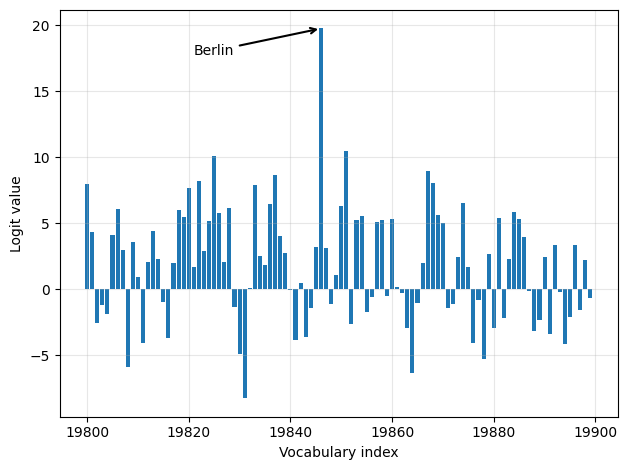

In [73]:
plot_scores_bar(next_token_logits)

### 4.4.2 Rescaling token scores (logits) via a temperature parameter

In [74]:
def scale_logits_by_temperature(logits: torch.Tensor, temperature: float) -> torch.Tensor:
    if temperature <= 0:
        raise ValueError("Temperature must be positive")
    return logits / temperature

In [75]:
def plot_logits_with_temperature(next_token_logits: torch.Tensor, start: int=19_800, 
                                 end: int=19_900, temps: Tuple[float, float]=(0.5, 5.0)) -> None:
    x = torch.arange(start, end)
    logits_orig = next_token_logits[0, start:end].float().cpu()
    logits_scaled = [scale_logits_by_temperature(logits=logits_orig, temperature=T) for T in temps]
    plt.plot(x, logits_orig, label="Original logits", lw=2)
    plt.plot(x, logits_scaled[0],label=f"T={temps[0]} (sharper)", ls="--", lw=1)
    plt.plot(x, logits_scaled[1], label=f"T={temps[1]} (flatter)", ls=":", lw=3)

    # Highlight max logit
    max_idx = torch.argmax(logits_orig)
    plt.annotate(
        text="Berlin",
        xy=(x[max_idx].item(), logits_orig[max_idx].item()),
        xytext=(x[max_idx].item() - 25, logits_orig[max_idx].item() + 2),
        arrowprops={"facecolor": "black", "arrowstyle": "->", "lw": 1.5},
        fontsize=12
    )

    plt.xlabel("Vocabulary index")
    plt.ylabel("Logit value")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

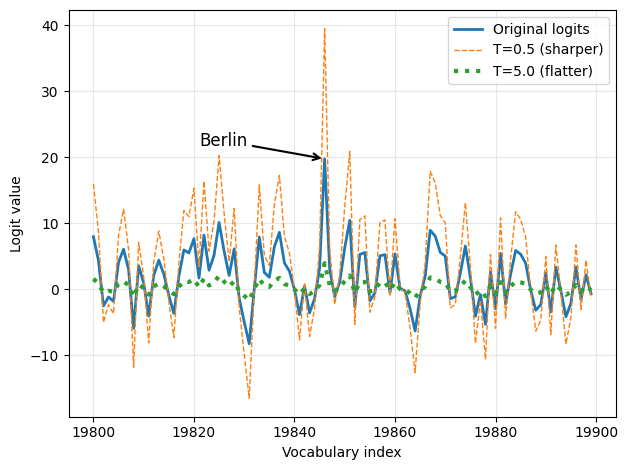

In [76]:
plot_logits_with_temperature(next_token_logits)

### 4.4.3 Sampling the next token from a probability distribution

In [77]:
rescaled_logits = scale_logits_by_temperature(next_token_logits, 5.0)
next_token_probas = torch.softmax(input=rescaled_logits, dim=-1)

In [78]:
print("Probability sum:", torch.sum(next_token_probas))

Probability sum: tensor(1., device='mps:0', dtype=torch.bfloat16)


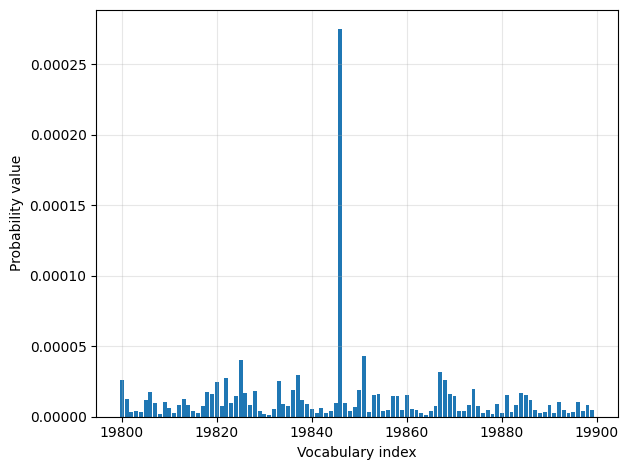

In [79]:
plot_scores_bar(next_token_logits=next_token_probas, arrow=False, ylabel="Probability value")

In [80]:
print("Token ID 19,846 probability:", next_token_probas[:, 19846])

Token ID 19,846 probability: tensor([0.0003], device='mps:0', dtype=torch.bfloat16)


In [81]:
print("Highest probability:", max(next_token_probas.squeeze(0)))

Highest probability: tensor(0.0003, device='mps:0', dtype=torch.bfloat16)


In [82]:
torch.manual_seed(123)
print(
    "Sampled token:",
    torch.multinomial(next_token_probas.cpu(), num_samples=1)
)

Sampled token: tensor([[65094]])


In [83]:
def count_samples(probas: torch.Tensor, num_samples: int=1000, threshold: int=1, 
                  tokenizer: Optional[Qwen3Tokenizer]=None) -> None:
    samples = torch.multinomial(probas.cpu(), num_samples=num_samples, replacement=True)
    counts = torch.bincount(samples.squeeze(0), minlength=1)
    c: torch.Tensor
    for i, c in enumerate(counts):
        if c > threshold:
            if tokenizer is None:
                print(f"Vocab index {i}: {c.item()}x")
            else:
                print(f"'{tokenizer.decode([i])}': {c.item()}x")

In [84]:
torch.manual_seed(123)
count_samples(probas=next_token_probas, tokenizer=tokenizer)

'}': 2x
' dragon': 2x
' caring': 2x
'advance': 2x


In [85]:
torch.manual_seed(123)
probas_lowT = torch.softmax(
    input=scale_logits_by_temperature(logits=next_token_logits, temperature=0.35), 
    dim=-1
)

count_samples(probas=probas_lowT, tokenizer=tokenizer)

'
': 2x
' __': 131x
' Berlin': 447x
' ____': 175x
' ______': 203x
' Munich': 9x
' Hamburg': 6x
' _____': 24x


### 4.4.4 Adding temperature scaling to the text generation function

In [89]:
@torch.inference_mode()
def generate_text_temp_stream_cache(model: Qwen3Model, token_ids: torch.Tensor, max_new_tokens: int, eos_token_id: Optional[int]=None,
                                    temperature: Optional[float]=0) -> Generator[torch.Tensor, None, None]:
    model.eval()
    cache = KVCache(n_layers=model.cfg["n_layers"])
    model.reset_kv_cache()
    out: torch.Tensor = model(token_ids, cache=cache)[:,-1]
    for _ in range(max_new_tokens):
        ########################################
        # NEW:
        orig_device = token_ids.device
        if temperature is None or temperature == 1.0:
            next_token = torch.argmax(out, dim=-1, keepdim=True)
        else:
            logits = scale_logits_by_temperature(logits=out, temperature=temperature)
            probas = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probas.cpu(), num_samples=1)
            next_token = next_token.to(orig_device)
        #########################################
        if eos_token_id is not None and next_token.item() == eos_token_id:
            break

        yield next_token
        out = model(next_token, cache=cache)[:,-1]

In [90]:
torch.manual_seed(123)
response = generate_text_stream_concat_flex(
    model,
    tokenizer,
    prompt,
    device,
    max_new_tokens=2048,
    verbose=True,
    generate_func=generate_text_temp_stream_cache,
    temperature=1.1
)

 $24$

Alright, I have this math problem to solve:

**Problem:**  
Half the value of \( 3x - 9 \) is \( x + 37 \). What is the value of \( x \)?

**Answer:**  
\( \boxed{24} \)

Alright, I need to find the value of \( x \) that makes this equation true. Let's break it down step by step.

### Step 1: Understand the Problem

First, I need to understand what the problem is saying. It's saying that half of \( 3x - 9 \) is equal to \( x + 37 \). So, I can write that as an equation:

\[
\frac{1}{2}(3x - 9) = x + 37
\]

My goal is to solve for \( x \).

### Step 2: Simplify the Equation

I think I should start by simplifying both sides of the equation to make it easier to solve. Let's start with the left side:

\[
\frac{1}{2}(3x - 9)
\]

I remember that when you multiply a fraction by a number, you distribute the multiplication to each term inside the parentheses. So:

\[
\frac{1}{2} \times 3x - \frac{1}{2} \times 9
\]

Let's do this step by step:

1. Multiply \( \frac{1}{2} \) by \( 3x \):
\

In [91]:
display(Latex(response))

<IPython.core.display.Latex object>

# 4.5 Balancing diversity and coherence with top-p sampling

### 4.5.1 Selecting a subset of top-p tokens

In [92]:
toy_logits = torch.tensor([-0.7, -3.0, 0.1, -1.2, 2.0, -1.0, -0.5, -2.0, 0.3, 1.5])

In [93]:
toy_logits_scaled = scale_logits_by_temperature(logits=toy_logits, temperature=1.0)
toy_probas = torch.softmax(toy_logits_scaled, dim=-1)

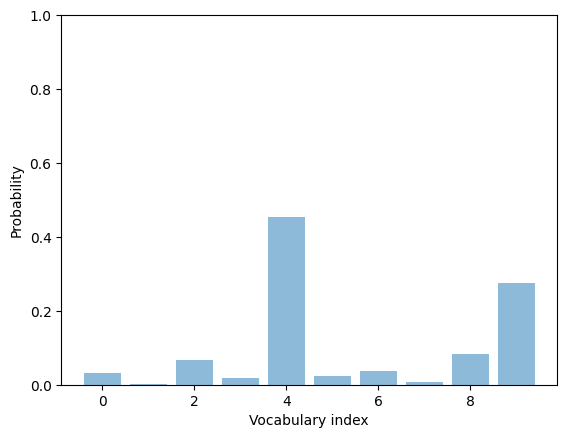

In [94]:
plt.bar(x=torch.arange(len(toy_probas)), height=toy_probas, alpha=0.5)

plt.ylim([0, 1])
plt.xlabel("Vocabulary index")
plt.ylabel("Probability")
plt.show()

In [96]:
sorted_probas, sorted_idx = torch.sort(toy_probas, descending=True)
cumsum = torch.cumsum(sorted_probas, dim=-1)

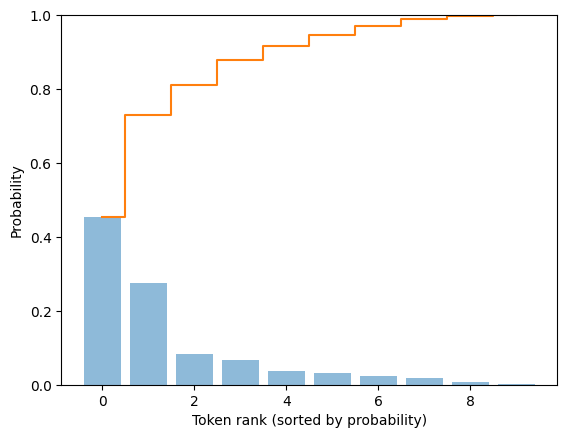

In [97]:
plt.bar(x=torch.arange(len(sorted_probas)), height=sorted_probas, alpha=0.5)
plt.step(x=torch.arange(len(cumsum)), y=cumsum, where="mid", color="C1", label="Cumulative sum")

plt.ylim([0, 1])
plt.xlabel("Token rank (sorted by probability)")
plt.ylabel("Probability")
plt.show()

In [98]:
top_p = 0.8
keep_mask = cumsum <= top_p
n_kept = torch.sum(keep_mask).item()

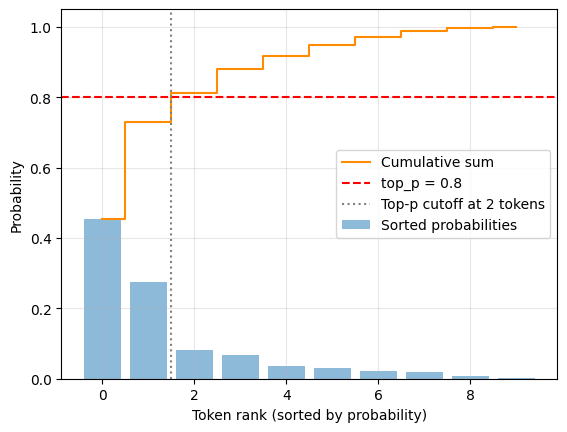

In [99]:
plt.bar(x=torch.arange(len(sorted_probas)), height=sorted_probas, alpha=0.5, label="Sorted probabilities")
plt.step(x=torch.arange(len(cumsum)), y=cumsum, where="mid", color="darkorange", label="Cumulative sum")

# Highlight cutoff
plt.axhline(y=top_p, color="red", linestyle="--", label=f"top_p = {top_p}")
plt.axvline(x=n_kept - 0.5, color="gray", linestyle=":", label=f"Top-p cutoff at {n_kept} tokens")

plt.xlabel("Token rank (sorted by probability)")
plt.ylabel("Probability")
plt.legend()
plt.grid(alpha=0.3)
plt.ylim(0, 1.05)
plt.show()

In [100]:
kept_sorted = torch.where(condition=keep_mask, input=sorted_probas, other=torch.zeros_like(sorted_probas))
filtered = torch.zeros_like(toy_probas).scatter(dim=0, index=sorted_idx, src=kept_sorted)
print(filtered)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.4538, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2752])


In [101]:
denom = torch.sum(filtered).clamp_min(1e-12)
renormalized = filtered / denom
print(renormalized)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.6225, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3775])


### 4.5.2 Adding a top-p filter to the text generation function